<a href="https://colab.research.google.com/github/andresperez86/Comparative_analysis_Competitive_strategies/blob/main/notebooks/load_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PASO 1 — Librerías

In [1]:
import os
import pandas as pd

# 1. Borrar la carpeta si ya existe (por si corres la celda varias veces)
!rm -rf Comparative_analysis_Competitive_strategies

# 2. Clonar tu repositorio de GitHub
!git clone https://github.com/andresperez86/Comparative_analysis_Competitive_strategies.git

# 3. Entrar a la carpeta del proyecto
%cd Comparative_analysis_Competitive_strategies

# 4. Verificar que la carpeta 'data' está ahí
if os.path.exists("data"):
    print("✅ Carpeta de datos cargada correctamente.")
    print("Archivos disponibles:", os.listdir("data"))

# 5. Ejemplo de carga de un archivo (EIA.xlsx)
# Ahora la ruta es simplemente 'data/nombre_archivo.xlsx'
df_eia = pd.read_excel("data/EIA.xlsx")
print("\nVista previa de EIA.xlsx:")
print(df_eia.head())

Cloning into 'Comparative_analysis_Competitive_strategies'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 41 (delta 8), reused 33 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 12.55 MiB | 12.81 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/Comparative_analysis_Competitive_strategies
✅ Carpeta de datos cargada correctamente.
Archivos disponibles: ['HELLMEC.xlsx', 'pascual bravo.xlsx', 'VTECCI.xlsx', 'KRATOS.xlsx', 'Sabana.xlsx', 'EIA.xlsx', 'OMEGA.xlsx']

Vista previa de EIA.xlsx:
                    timestamp  car_velocity  car_trip  car_velocity_gps  \
0  2025-11-07T20:18:02.837767           0.0       0.0              0.00   
1  2025-11-07T20:18:03.843626           0.0       0.0             16.65   
2  2025-11-07T20:18:04.845043           0.0       0.0             31.45   
3  2025-11-07T20:18:05.847000           0.0       0.0             33.30   
4  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

PASO 2 — Cargar todos los equipos automáticamente

In [5]:
import os
print(os.getcwd())

/content/Comparative_analysis_Competitive_strategies


In [6]:
files = {
    "EIA": "/content/Comparative_analysis_Competitive_strategies/data/EIA.xlsx",
    "HELLMEC": "/content/Comparative_analysis_Competitive_strategies/data/HELLMEC.xlsx",
    "KRATOS": "/content/Comparative_analysis_Competitive_strategies/data/OMEGA.xlsx",
    "PASCUAL": "/content/Comparative_analysis_Competitive_strategies/data/pascual bravo.xlsx",
    "SABANA": "/content/Comparative_analysis_Competitive_strategies/data/Sabana.xlsx",
    "VTECCI": "/content/Comparative_analysis_Competitive_strategies/data/VTECCI.xlsx",
}

dfs = {}

#file_path = os.path.join("..", "/content/data", "EIA.xlsx")

for team, path in files.items():
  print(f"Loading data for {team} from {path}")
  df = pd.read_excel(path)
  df["team"] = team
  dfs[team] = df

Loading data for EIA from /content/Comparative_analysis_Competitive_strategies/data/EIA.xlsx
Loading data for HELLMEC from /content/Comparative_analysis_Competitive_strategies/data/HELLMEC.xlsx
Loading data for KRATOS from /content/Comparative_analysis_Competitive_strategies/data/OMEGA.xlsx
Loading data for PASCUAL from /content/Comparative_analysis_Competitive_strategies/data/pascual bravo.xlsx
Loading data for SABANA from /content/Comparative_analysis_Competitive_strategies/data/Sabana.xlsx
Loading data for VTECCI from /content/Comparative_analysis_Competitive_strategies/data/VTECCI.xlsx


PASO 3 — Limpieza y estandarización

In [7]:
def clean_data(df):
    df = df.copy()
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.sort_values("timestamp")

    numeric_cols = ["car_velocity", "car_voltage", "car_current", "power"]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(subset=["timestamp"])
    df["dt"] = df["timestamp"].diff().dt.total_seconds()
    df["dt"] = df["dt"].fillna(0)

    return df

for team in dfs:
    dfs[team] = clean_data(dfs[team])

PASO 4 — Cálculo de energía y eficiencia

In [8]:
def compute_metrics(df):
    df = df.copy()

    # Energía en Wh
    df["energy_Wh"] = (df["power"] * df["dt"]) / 3600

    total_energy = df["energy_Wh"].sum()

    # Distancia
    if "car_trip" in df.columns and df["car_trip"].max() > 0:
        distance = df["car_trip"].max()
    else:
        df["distance_m"] = df["car_velocity"] * df["dt"]
        distance = df["distance_m"].sum() / 1000

    efficiency = total_energy / distance if distance > 0 else np.nan

    return {
        "Energy_Wh": total_energy,
        "Distance_km": distance,
        "Efficiency_Wh_per_km": efficiency,
        "Mean_Speed": df["car_velocity"].mean(),
        "Speed_std": df["car_velocity"].std(),
        "Power_mean": df["power"].mean(),
        "Power_p95": df["power"].quantile(0.95),
        "Coasting_ratio": np.mean(np.abs(df["power"]) < 5),
        "Regen_ratio": np.mean(df["power"] < 0)
    }

summary = []

for team, df in dfs.items():
    metrics = compute_metrics(df)
    metrics["Team"] = team
    summary.append(metrics)

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("Efficiency_Wh_per_km")
summary_df

,Energy_Wh,Distance_km,Efficiency_Wh_per_km,Mean_Speed,Speed_std,Power_mean,Power_p95,Coasting_ratio,Regen_ratio,Team
3,144.736338,19.048840,7.598171,7.043440,13.131078,81.428249,633.722710,0.473996,0.327151,PASCUAL
0,252.268611,19.118094,13.195281,10.988073,16.419881,144.697256,868.951920,0.588401,0.249805,EIA
2,289.586662,20.612289,14.049224,4.396387,11.144329,62.506562,521.634168,0.802406,0.543493,KRATOS
1,134.346895,6.322658,21.248482,1.747278,29.245639,36.244367,139.277783,0.616202,0.205711,HELLMEC
4,192.156354,0.000000,NaN,0.000000,0.000000,43.034747,413.208369,0.815331,0.351971,SABANA
5,233.571604,0.000000,NaN,0.000000,0.000000,78.398144,589.189507,0.657597,0.068814,VTECCI


📌 Esta tabla es la principal del paper.

Guardar:

In [9]:
summary_df.to_csv("/content/Comparative_analysis_Competitive_strategies/outputs/team_summary.csv", index=False)#/content/Comparative_analysis_Competitive_strategies/outputs

#🔹 PASO 5 — Visualizaciones clave
1️⃣ Ranking eficiencia

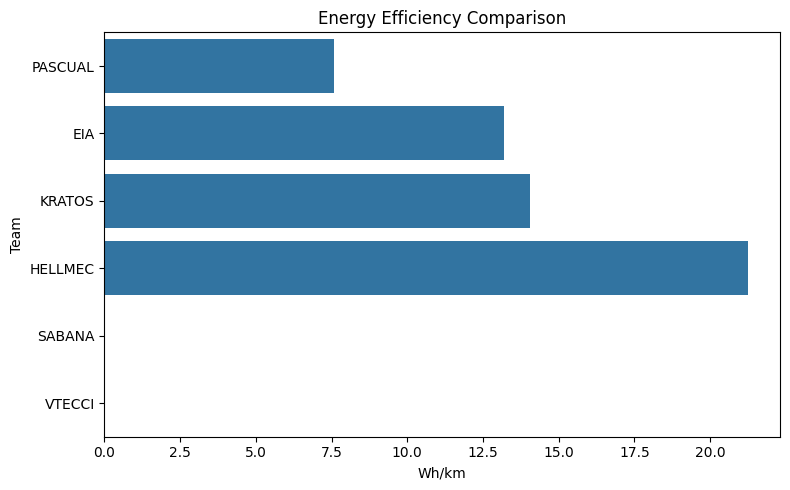

In [10]:
plt.figure(figsize=(8,5))
sns.barplot(data=summary_df, x="Efficiency_Wh_per_km", y="Team")
plt.title("Energy Efficiency Comparison")
plt.xlabel("Wh/km")
plt.tight_layout()
plt.savefig("efficiency_ranking.png")
plt.show()

2️⃣ Potencia vs tiempo (ejemplo KRATOS)

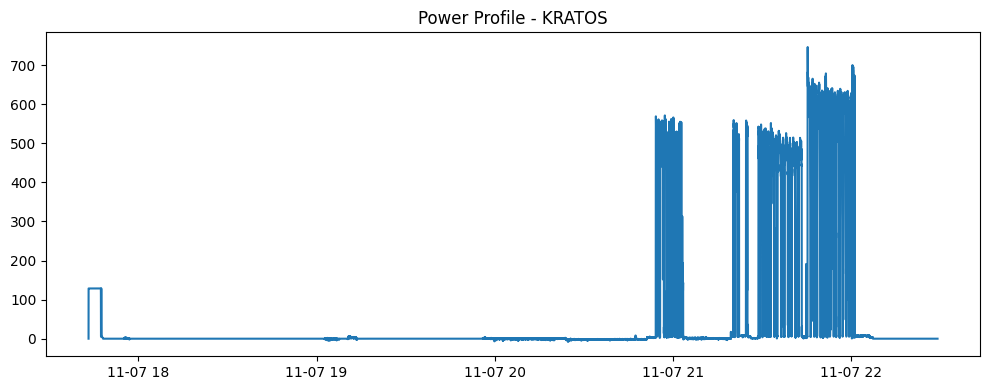

In [11]:
df = dfs["KRATOS"]
plt.figure(figsize=(10,4))
plt.plot(df["timestamp"], df["power"])
plt.title("Power Profile - KRATOS")
plt.tight_layout()
plt.savefig("kratos_power.png")
plt.show()

3️⃣ Velocidad vs Potencia

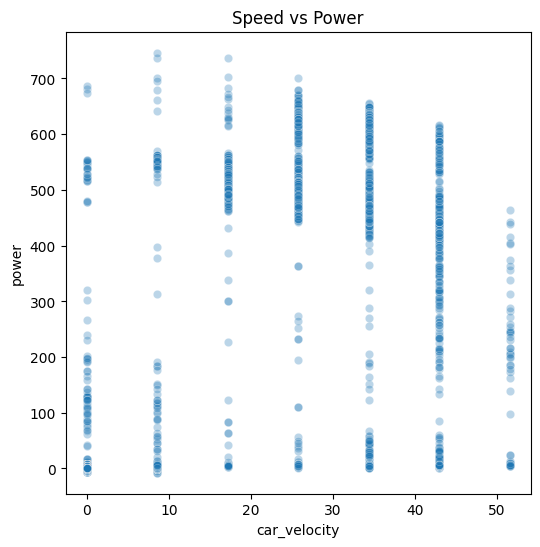

In [12]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x="car_velocity", y="power", alpha=0.3)
plt.title("Speed vs Power")
plt.savefig("speed_vs_power.png")#outputs/figures/speed_vs_power.png
plt.show()

Potencia vs tiempo (ejemplo PascualBravo)

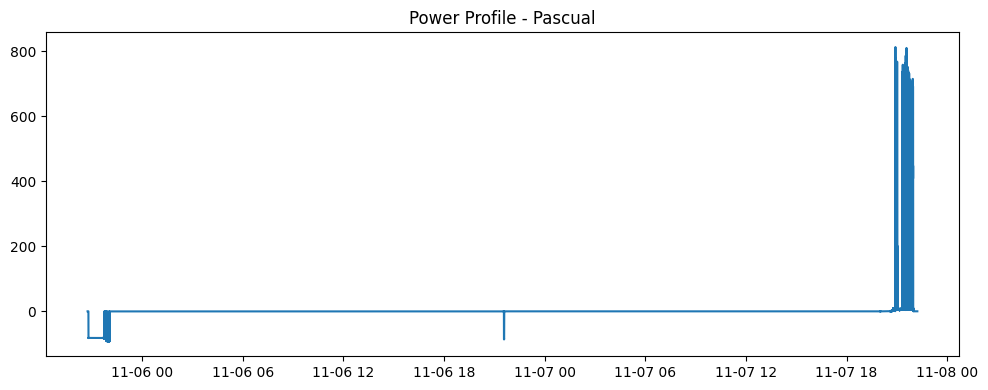

In [13]:
df = dfs["PASCUAL"]
plt.figure(figsize=(10,4))
plt.plot(df["timestamp"], df["power"])
plt.title("Power Profile - Pascual")
plt.tight_layout()
plt.savefig("pascual_power.png")
plt.show()

3️⃣ Velocidad vs Potencia

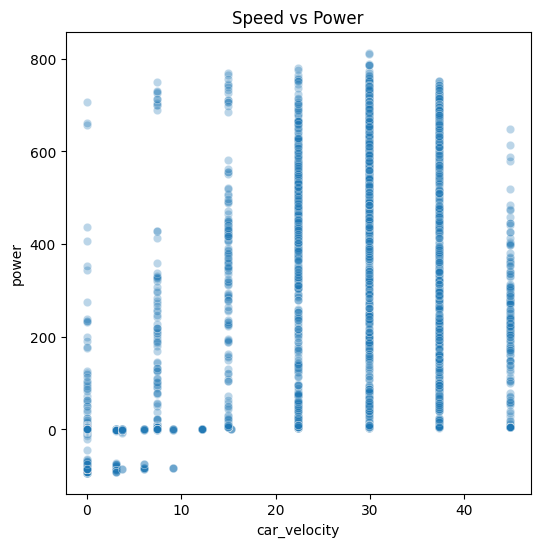

In [14]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x="car_velocity", y="power", alpha=0.3)
plt.title("Speed vs Power")
plt.savefig("speed_vs_power.png")
plt.show()

#🔹 PASO 6 — Minería de datos (Clustering por ventanas)
Crear ventanas de 30 segundos

In [15]:
def create_windows(df, window=30):
    df = df.copy()
    df["window_id"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds() // window

    features = df.groupby("window_id").agg({
        "car_velocity": ["mean", "std"],
        "power": ["mean", lambda x: np.percentile(x, 95)],
        "dt": "sum"
    })

    features.columns = ["v_mean","v_std","p_mean","p_p95","duration"]
    features = features.reset_index()
    return features

window_data = []

for team, df in dfs.items():
    w = create_windows(df)
    w["team"] = team
    window_data.append(w)

windows_df = pd.concat(window_data)

Normalizar

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(windows_df[["v_mean","v_std","p_mean","p_p95"]])

1) Plantilla robusta: PCA + múltiples gráficos (sin errores de guardado)

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


def safe_savefig(output_dir: str, filename: str, dpi: int = 300):
    ensure_dir(output_dir)
    save_path = os.path.join(output_dir, filename)
    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    print(f"✅ Guardado: {save_path}")


def run_pca_and_plots(
    df: pd.DataFrame,
    features: list,
    color_col: str = None,          # "cluster" o "team"
    output_dir: str = "outputs/figures",
    prefix: str = "pca",
    scale: bool = True,
):
    # --- 1) limpiar NaNs/infs en features
    X = df[features].copy()
    X = X.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    idx = X.index

    # colores alineados con X
    c = None
    if color_col is not None and color_col in df.columns:
        c = df.loc[idx, color_col].values # Convert to numpy array

    # --- 2) escalar
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.values

    # --- 3) PCA completo (para scree)
    pca_full = PCA()
    Z_full = pca_full.fit_transform(X_scaled)
    evr = pca_full.explained_variance_ratio_

    # Scree plot
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(evr) + 1), evr, marker="o")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Scree Plot (Explained Variance)")
    plt.grid(True, alpha=0.3)
    safe_savefig(output_dir, f"{prefix}_scree.png")
    plt.show()

    # --- 4) PCA 2D: PC1 vs PC2
    pca2 = PCA(n_components=2)
    Z2 = pca2.fit_transform(X_scaled)

    plt.figure(figsize=(7, 6))
    if c is None:
        plt.scatter(Z2[:, 0], Z2[:, 1], alpha=0.7)
    else:
        plt.scatter(Z2[:, 0], Z2[:, 1], c="g", cmap="viridis", alpha=0.75)
        plt.colorbar(label=color_col)

    plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}%)的发展和趋势")
    plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}%)的发展和趋势")
    plt.title("PCA: PC1 vs PC2")
    plt.grid(True, alpha=0.3)
    safe_savefig(output_dir, f"{prefix}_pc1_pc2.png")
    plt.show()

    # --- 5) PCA 3 componentes para PC1-PC3 y PC2-PC3
    pca3 = PCA(n_components=3)
    Z3 = pca3.fit_transform(X_scaled)

    # PC1 vs PC3
    plt.figure(figsize=(7, 6))
    if c is None:
        plt.scatter(Z3[:, 0], Z3[:, 2], alpha=0.7)
    else:
        plt.scatter(Z3[:, 0], Z3[:, 2], c="g", cmap="viridis", alpha=0.75)
        plt.colorbar(label=color_col)

    plt.xlabel(f"PC1 ({pca3.explained_variance_ratio_[0]*100:.1f}%)的发展和趋势")
    plt.ylabel(f"PC3 ({pca3.explained_variance_ratio_[2]*100:.1f}%)的发展和趋势")
    plt.title("PCA: PC1 vs PC3")
    plt.grid(True, alpha=0.3)
    safe_savefig(output_dir, f"{prefix}_pc1_pc3.png")
    plt.show()

    # PC2 vs PC3
    plt.figure(figsize=(7, 6))
    if c is None:
        plt.scatter(Z3[:, 1], Z3[:, 2], alpha=0.7)
    else:
        plt.scatter(Z3[:, 1], Z3[:, 2], c="g", cmap="viridis", alpha=0.75)
        plt.colorbar(label=color_col)

    plt.xlabel(f"PC2 ({pca3.explained_variance_ratio_[1]*100:.1f}%)的发展和趋势")
    plt.ylabel(f"PC3 ({pca3.explained_variance_ratio_[2]*100:.1f}%)的发展和趋势")
    plt.title("PCA: PC2 vs PC3")
    plt.grid(True, alpha=0.3)
    safe_savefig(output_dir, f"{prefix}_pc2_pc3.png")
    plt.show()

    # --- 6) Biplot (PC1-PC2) con cargas (loadings)
    loadings = pca2.components_.T  # shape: (n_features, 2)

    plt.figure(figsize=(7, 6))
    plt.scatter(Z2[:, 0], Z2[:, 1], alpha=0.35)
    # escala de flechas (ajustable)
    arrow_scale = 3.0

    for i, feat in enumerate(features):
        plt.arrow(
            0, 0,
            loadings[i, 0] * arrow_scale,
            loadings[i, 1] * arrow_scale,
            alpha=0.8,
            width=0.005,
            head_width=0.08,
            length_includes_head=True
        )
        plt.text(
            loadings[i, 0] * arrow_scale * 1.1,
            loadings[i, 1] * arrow_scale * 1.1,
            feat
        )

    plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}%)的发展和趋势")
    plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}%)的发展和趋势")
    plt.title("PCA Biplot (PC1-PC2)")
    plt.grid(True, alpha=0.3)
    safe_savefig(output_dir, f"{prefix}_biplot.png")
    plt.show()

    # devuelve objetos por si quieres usarlos después
    return {
        "pca_full": pca_full,
        "pca2": pca2,
        "pca3": pca3,
        "X_index": idx
    }

2) Cómo usarlo con tu windows_df
A) PCA coloreado por cluster

✅ Guardado: outputs/figures/strategies_cluster_scree.png


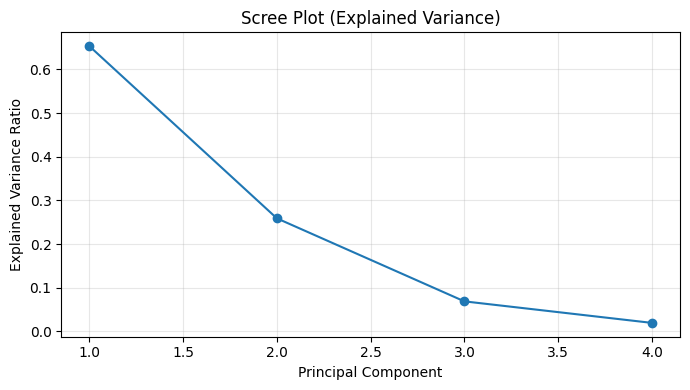

/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:18: UserWarning: Glyph 30340 (\N{CJK UN

✅ Guardado: outputs/figures/strategies_cluster_pc1_pc2.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  fig.canvas

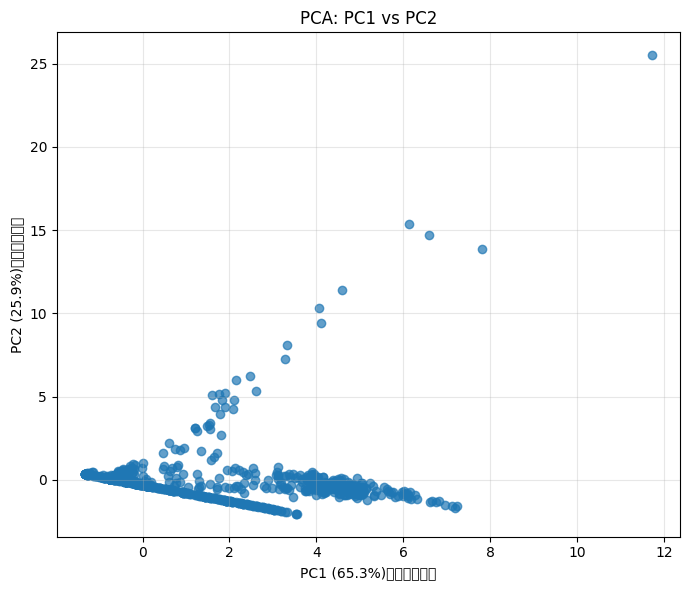

/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:18: UserWarning: Glyph 30340 (\N{CJK UN

✅ Guardado: outputs/figures/strategies_cluster_pc1_pc3.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  fig.canvas

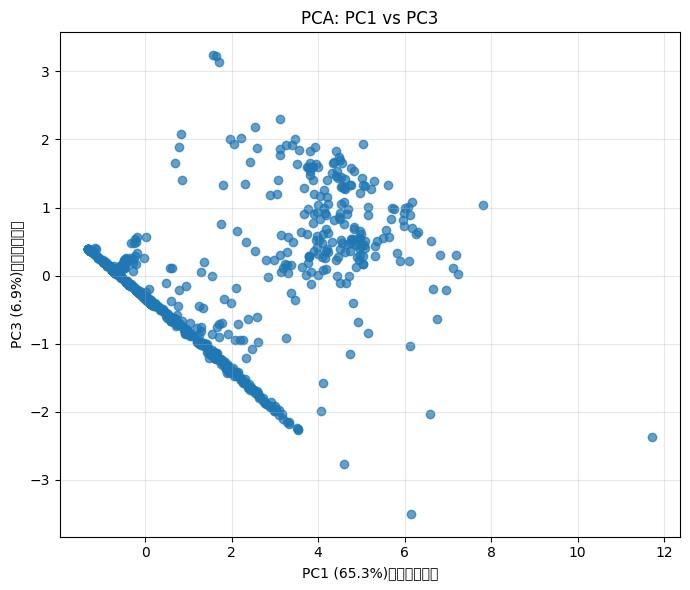

✅ Guardado: outputs/figures/strategies_cluster_pc2_pc3.png


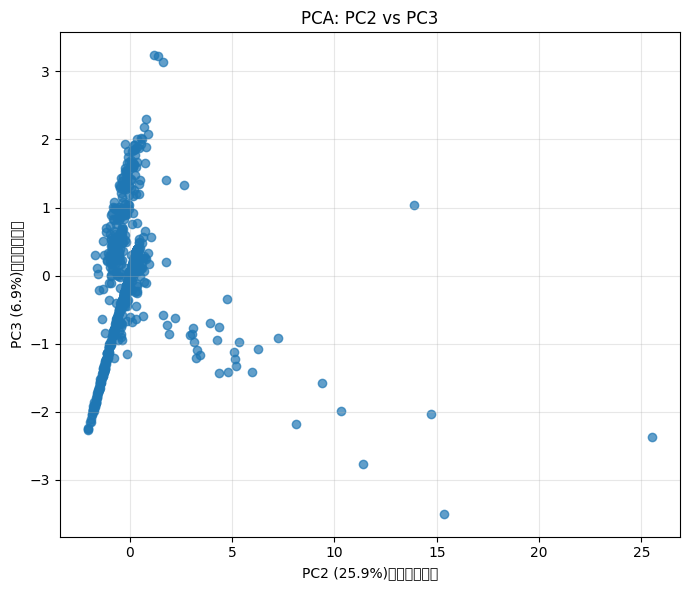

✅ Guardado: outputs/figures/strategies_cluster_biplot.png


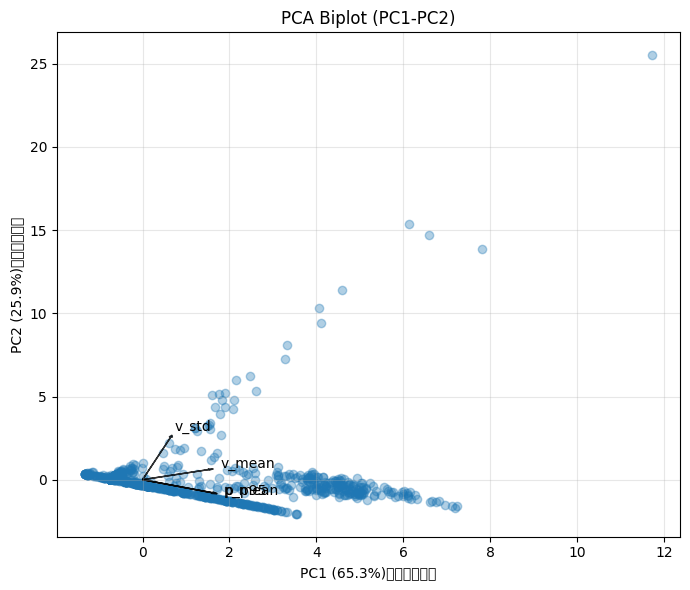

In [18]:
features = ["v_mean", "v_std", "p_mean", "p_p95"]  # ajusta a tus columnas reales
res = run_pca_and_plots(
    df=windows_df,
    features=features,
    color_col="cluster",
    output_dir="outputs/figures",
    prefix="strategies_cluster",
    scale=True
)

✅ Guardado: outputs/figures/strategies_cluster_scree.png


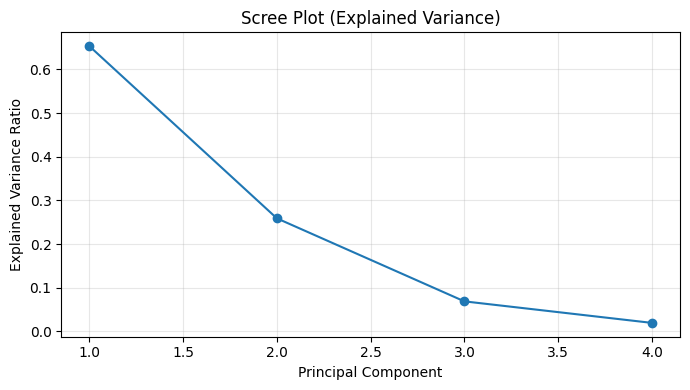

/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:18: UserWarning: Glyph 30340 (\N{CJK UN

✅ Guardado: outputs/figures/strategies_cluster_pc1_pc2.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  fig.canvas

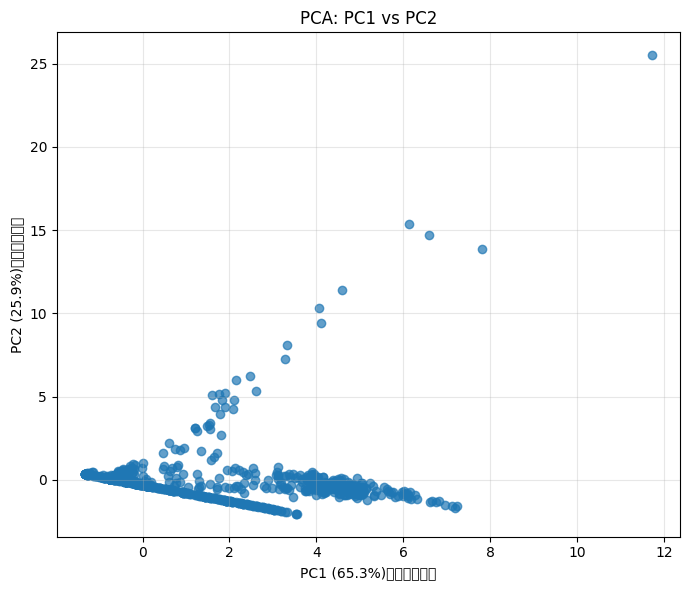

/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:18: UserWarning: Glyph 30340 (\N{CJK UN

✅ Guardado: outputs/figures/strategies_cluster_pc1_pc3.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  fig.canvas

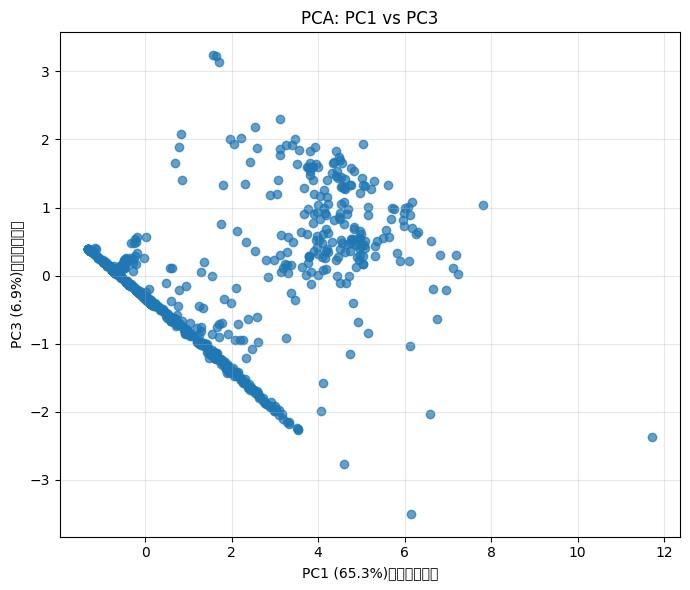

✅ Guardado: outputs/figures/strategies_cluster_pc2_pc3.png


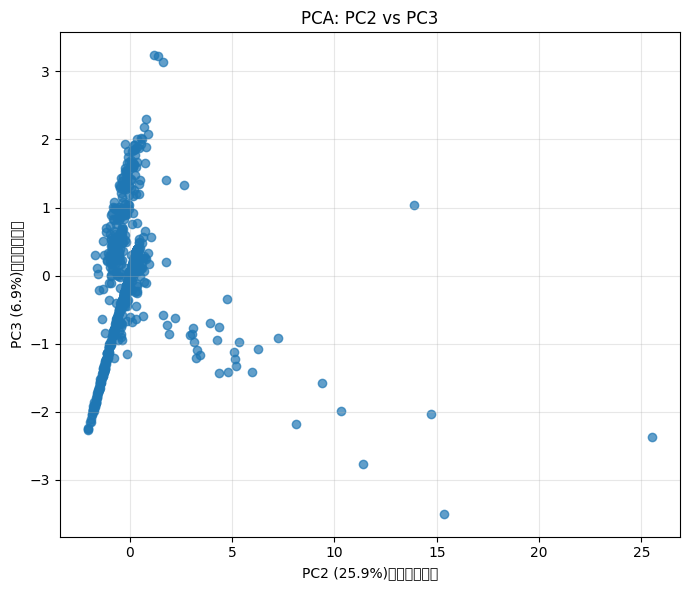

✅ Guardado: outputs/figures/strategies_cluster_biplot.png


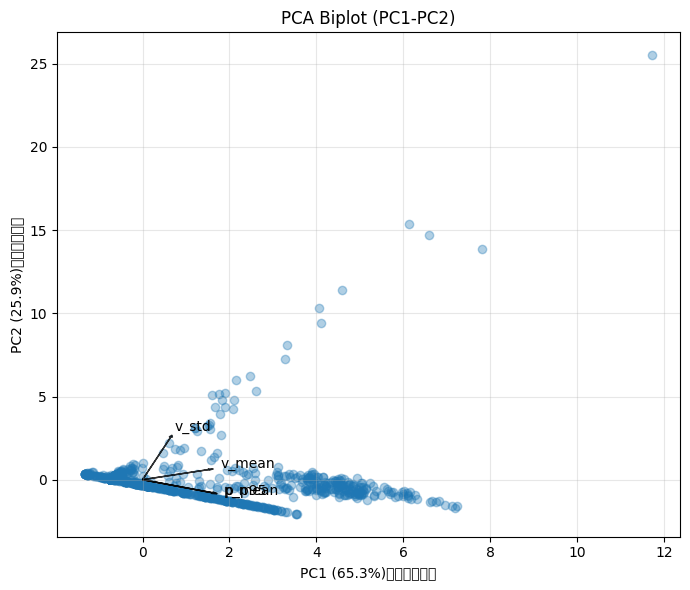

In [19]:
features = ["v_mean", "v_std", "p_mean", "p_p95"]  # ajusta a tus columnas reales
res = run_pca_and_plots(
    df=windows_df,
    features=features,
    color_col="cluster",
    output_dir="outputs/figures",
    prefix="strategies_cluster",
    scale=True
)

✅ Guardado: outputs/figures/strategies_team_scree.png


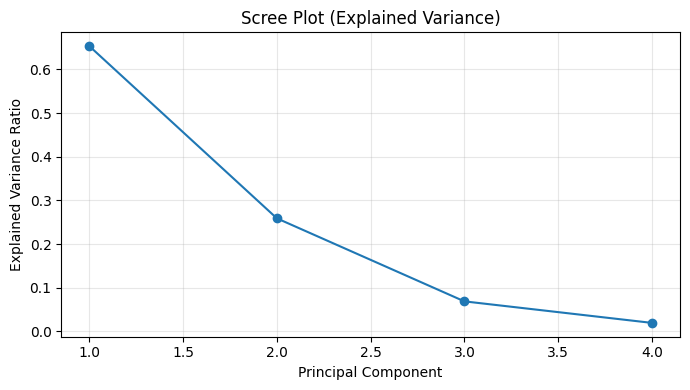

/tmp/ipython-input-207/2109764357.py:70: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z2[:, 0], Z2[:, 1], c="g", cmap="viridis", alpha=0.75)
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764

✅ Guardado: outputs/figures/strategies_team_pc1_pc2.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  fig.canvas

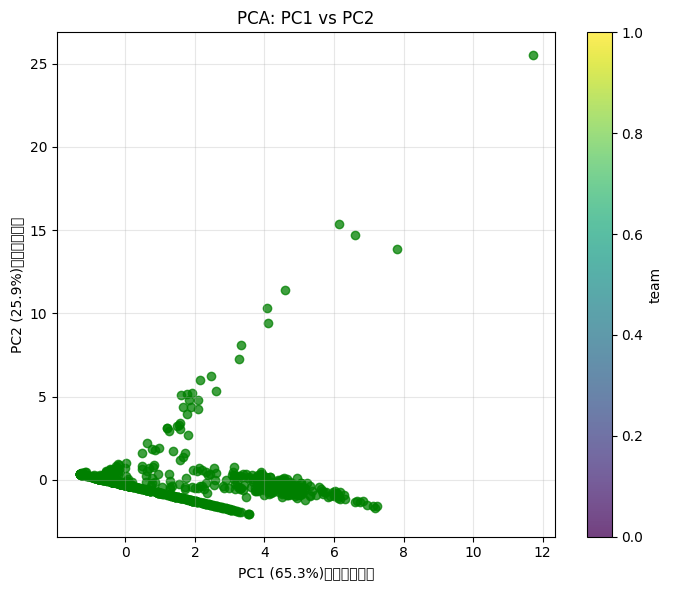

/tmp/ipython-input-207/2109764357.py:89: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z3[:, 0], Z3[:, 2], c="g", cmap="viridis", alpha=0.75)
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764357.py:17: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-207/2109764

✅ Guardado: outputs/figures/strategies_team_pc1_pc3.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  fig.canvas

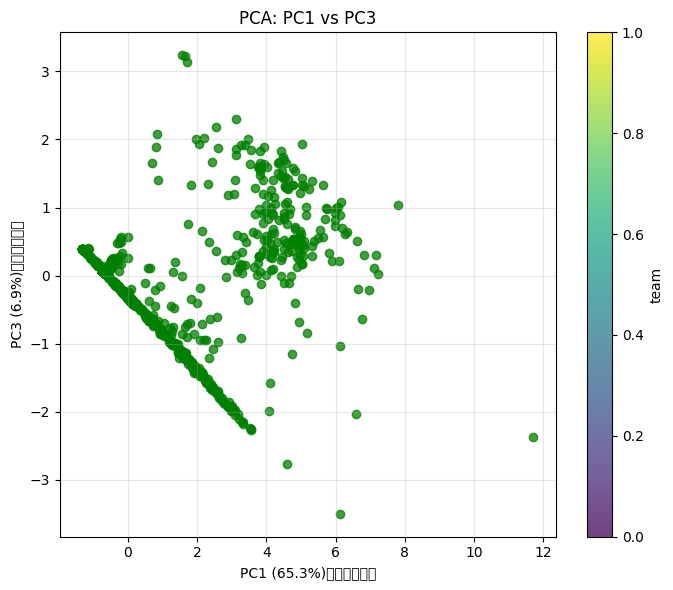

/tmp/ipython-input-207/2109764357.py:104: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z3[:, 1], Z3[:, 2], c="g", cmap="viridis", alpha=0.75)


✅ Guardado: outputs/figures/strategies_team_pc2_pc3.png


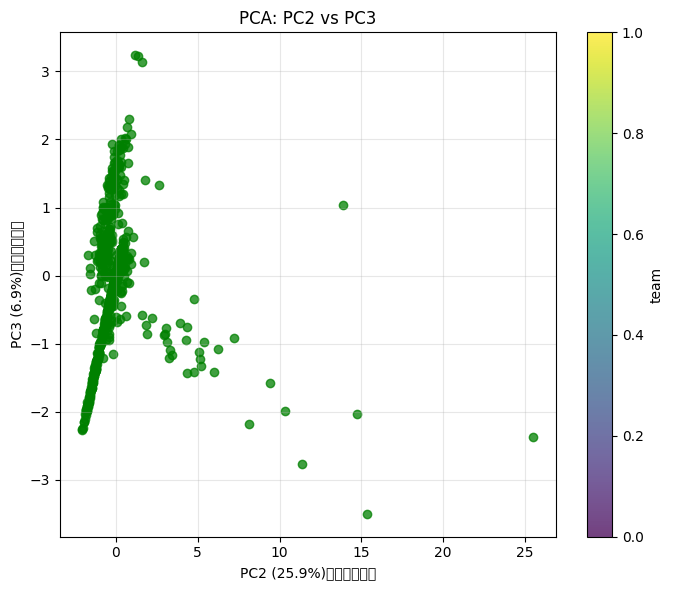

✅ Guardado: outputs/figures/strategies_team_biplot.png


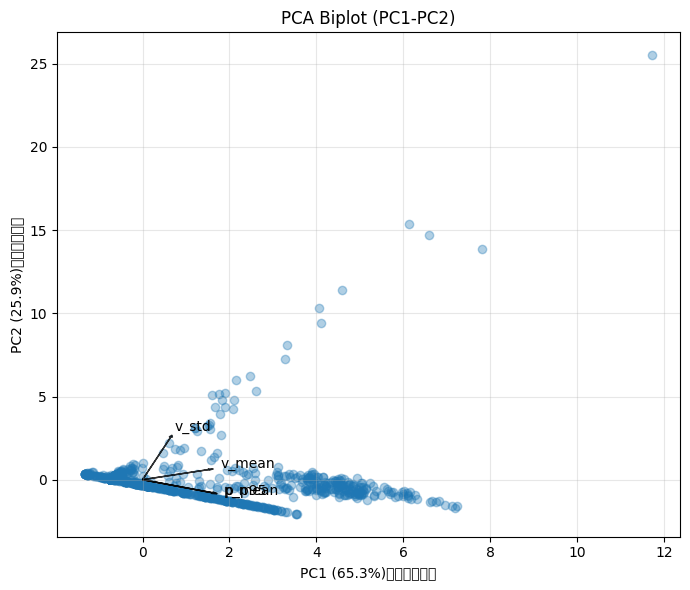

In [21]:
res = run_pca_and_plots(
    df=windows_df,
    features=features,
    color_col="team",
    output_dir="outputs/figures",
    prefix="strategies_team",
    scale=True
)

K-Means

In [27]:
# Identify feature columns
feature_cols = ["v_mean", "v_std", "p_mean", "p_p95"]

# Impute NaN values
# Fill 'v_std' NaNs with 0 (assuming no variance for constant windows)
windows_df['v_std'] = windows_df['v_std'].fillna(0)

# Fill 'v_mean', 'p_mean', 'p_p95' NaNs with the mean of their respective columns
for col in ["v_mean", "p_mean", "p_p95"]:
    windows_df[col] = windows_df[col].fillna(windows_df[col].mean())

# Re-initialize and fit scaler on the imputed data
scaler_cleaned = StandardScaler()
X_cleaned = scaler_cleaned.fit_transform(windows_df[feature_cols])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto') # n_init='auto' for future compatibility
windows_df["cluster"] = kmeans.fit_predict(X_cleaned)

PCA para visualización

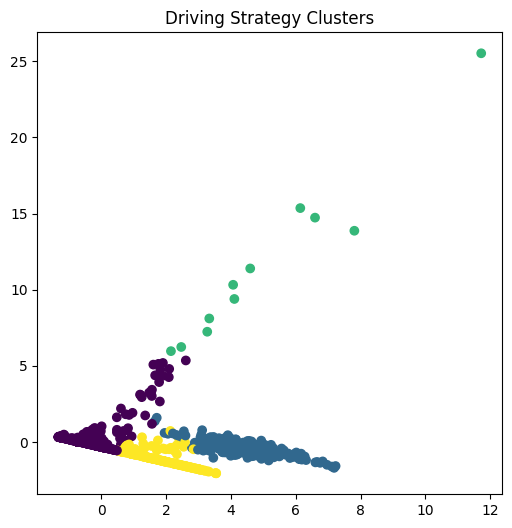

In [42]:
import os

# Create the directory if it doesn't exist
output_dir = "outputs/figures"
os.makedirs(output_dir, exist_ok=True)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cleaned)

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=windows_df["cluster"], cmap="viridis")
plt.title("Driving Strategy Clusters")
plt.savefig(os.path.join(output_dir, "clusters.png"))
plt.show()

En el paper interpretas cada cluster como estrategia:

Cluster 0: conducción suave

Cluster 1: agresiva

etc.

#🔹 PASO 7 — Modelo predictivo (Wh/km por ventana)
Crear target

In [32]:
windows_df["efficiency"] = windows_df["p_mean"]  # proxy por ventana

(Mejor aún: energía ventana / distancia ventana)

Train/test split

In [33]:
X = windows_df[["v_mean","v_std","p_mean","p_p95"]]
y = windows_df["efficiency"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Modelo 1 — Ridge

In [34]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

y_pred = model_ridge.predict(X_test)

print("Ridge MAE:", mean_absolute_error(y_test, y_pred))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Ridge R2:", r2_score(y_test, y_pred))

Ridge MAE: 4.396284743757045e-06
Ridge RMSE: 1.1102906945545156e-05
Ridge R2: 0.9999999999999946


Modelo 2 — Random Forest

In [35]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("RF MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("RF R2:", r2_score(y_test, y_pred_rf))

RF MAE: 0.3273061253187448
RF RMSE: 2.256481913963899
RF R2: 0.9997739524520886


Importancia de variables

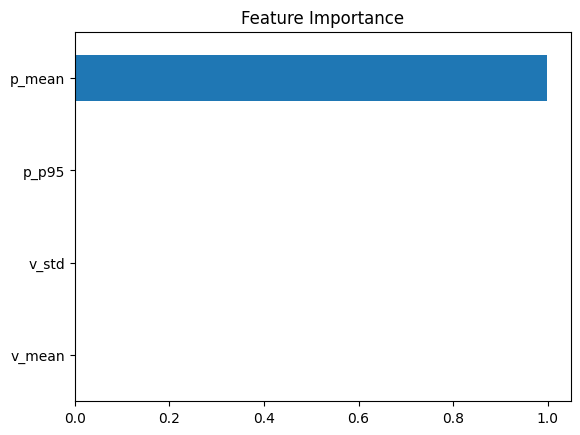

In [36]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh")
plt.title("Feature Importance")
plt.savefig("outputs/figures/feature_importance.png")
plt.show()

#🔹 PASO 8 — Análisis estadístico formal
ANOVA eficiencia

In [37]:
groups = [dfs[team]["power"].dropna() for team in dfs]
stats.f_oneway(*groups)

F_onewayResult(statistic=np.float64(444.5409635526774), pvalue=np.float64(0.0))

Si no normal → Kruskal:

In [39]:
stats.kruskal(*groups)

KruskalResult(statistic=np.float64(7258.461986492431), pvalue=np.float64(0.0))

✅. Tabla comparativa por equipo

✅. Ranking de eficiencia

✅. Identificación de estrategias por clustering

✅ Modelo predictivo con MAE/RMSE/R²

✅ Importancia de variables

✅ Figuras listas para paper